# Collecte des données ``non_covid``

### Importation des bibliothèques et de leurs packages

In [1]:
# Fonctions 'bash'
import os
import sys
from pathlib import Path

# Connexion à la base de données Mongo
import pymongo
from pymongo import MongoClient, ASCENDING, DESCENDING

# Collecte des données et écriture
import json
from bson import json_util, ObjectId

from collections import defaultdict
import csv

import string

# Recherche d'expressions régulières
import re
from unidecode import unidecode # transormation

# Mise en forme du texte python
from pprint import pprint

# Connexion à Wikidata
from wikidata.client import Client

# Gestion des formats 'date'
from datetime import datetime, date, time, timedelta

# Visualisation des données
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd

# Traitement du langage naturel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


### Connexion à la base de données

In [2]:
host = "ec2-15-188-255-64.eu-west-3.compute.amazonaws.com" 
port = 27017
username = "semal"
password = "$hMN3PU]V][xR]zn"

mongo_client = MongoClient(host=host, port=port, username=username, password=password)

db = mongo_client["media_analysis"]["articles"]


### Extraction des fichiers ``json`` "non-covid"

#### Choix des sources à extraire

In [3]:
relevant_sources = [
    "lesoir.be",
    "lalibre.be",
    "rtbf.be",
    "rtlinfo.be",
    "dhnet.be",
    "sudinfo.be",
    "lavenir.net",
    "lecho.be",
    "levif.be"
]

#### Extraction des articles "non-covid"

In [4]:
import os
import json
from datetime import datetime, timedelta

def extract_data_non_covid(relevant_sources):
    if not os.path.exists(f"./data/non_covid/"):
            os.mkdir(f"./data/non_covid/")
            
    for source in relevant_sources:
        
        print(f"\n{source}")
        print("-------------------")

        if not os.path.exists(f"./data/non_covid/{source}"):
            os.mkdir(f"./data/non_covid/{source}")

        start_date = datetime(2020, 5, 1)
        delta = timedelta(days=1)
        end_date = datetime.now() - delta
    
        while start_date < end_date:
            current_date = start_date.strftime("%Y%m%d")
            source_dir = f"./data/{source}"
            
            filename = f"{source}_{current_date}.json"
            output_path = os.path.join(f"./data/non_covid/{source}", filename)

            if not os.path.isfile(output_path):
                extracted_oid_set = set()
                for file_name in os.listdir(source_dir):
                    if file_name == f"{source}_{current_date}.json":
                        file_path = os.path.join(source_dir, file_name)

                        with open(file_path, "r", encoding="utf-8") as file:
                            for line in file:
                                data = json.loads(line)
                                _oid = data["_id"]["$oid"]
                                extracted_oid_set.add(_oid)

                query = {
                    "_id": {
                        "$nin": [ObjectId(oid) for oid in extracted_oid_set]
                    },
                    "meta.source.name": source,
                    "date": {
                        "$gte": start_date,
                        "$lt": start_date + delta
                    },
                }
                projection = {
                    "_id": 1,
                    "date": 1,
                    "meta.source.name": 1,
                    "title": 1,
                    "text": 1
                }
                subset = db.find(query, projection).sort("date", ASCENDING)
                subset_count = db.count_documents(query)
                print(f"Nombre de documents à écrire pour {source} le {start_date.date()}: {subset_count}")

                try:
                    with open(output_path, "w", encoding="utf-8") as f:
                        for document in subset:
                            json.dump(document, f, default=json_util.default, ensure_ascii=False)
                            f.write("\n")
                except IOError as e:
                    print(f"Erreur lors de l'écriture du fichier {output_path}: {str(e)}")

            start_date += delta

    print("\nExctraction du subset non_covid OK")
    

In [5]:
extract_data_non_covid(relevant_sources)


lesoir.be
-------------------
Nombre de documents à écrire pour lesoir.be le 2024-05-13: 150
Nombre de documents à écrire pour lesoir.be le 2024-05-14: 0

lalibre.be
-------------------
Nombre de documents à écrire pour lalibre.be le 2024-05-13: 267
Nombre de documents à écrire pour lalibre.be le 2024-05-14: 255

rtbf.be
-------------------
Nombre de documents à écrire pour rtbf.be le 2024-05-13: 187
Nombre de documents à écrire pour rtbf.be le 2024-05-14: 181

rtlinfo.be
-------------------
Nombre de documents à écrire pour rtlinfo.be le 2024-05-13: 0
Nombre de documents à écrire pour rtlinfo.be le 2024-05-14: 0

dhnet.be
-------------------
Nombre de documents à écrire pour dhnet.be le 2024-05-13: 315
Nombre de documents à écrire pour dhnet.be le 2024-05-14: 276

sudinfo.be
-------------------
Nombre de documents à écrire pour sudinfo.be le 2024-05-13: 362
Nombre de documents à écrire pour sudinfo.be le 2024-05-14: 0

lavenir.net
-------------------
Nombre de documents à écrire pour

#### Extraction des thématiques et des entités avec update des fichiers JSON

In [6]:
relevant_sources = [
    "lesoir.be",
    "lalibre.be",
    "rtbf.be",
    "rtlinfo.be",
    "dhnet.be",
    "sudinfo.be",
    "lavenir.net",
    "lecho.be",
    "levif.be"
]

def extract_document_ids_and_data_from_file(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            data = json.loads(line)
            oid = data["_id"]["$oid"]
            yield oid, data

def get_topics_and_entities(document):
    coarseTopics = document.get("textrazor_response", {}).get("response", {}).get("coarseTopics", [])
    topics = document.get("textrazor_response", {}).get("response", {}).get("topics", [])
    entities = document.get("textrazor_response", {}).get("response", {}).get("entities", [])

    coarseTopics_set = set()
    for coarseTopic in coarseTopics:
        if coarseTopic["score"] >= 0.8:
            extracted_coarseTopic = {
                "label": coarseTopic["label"],
                "score": coarseTopic["score"]
            }
            coarseTopics_set.add(json.dumps(extracted_coarseTopic, ensure_ascii=False))

    extracted_coarseTopics = sorted([json.loads(coarseTopic) for coarseTopic in coarseTopics_set], key=lambda x: x["score"], reverse=True)

    topics_set = set()
    for topic in topics:
        if topic["score"] >= 0.8:
            extracted_topic = {
                "label": topic["label"],
                "score": topic["score"]
            }
            topics_set.add(json.dumps(extracted_topic, ensure_ascii=False))

    extracted_topics = sorted([json.loads(topic) for topic in topics_set], key=lambda x: x["score"], reverse=True)

    entities_set = set()
    for entity in entities:
        if entity["confidenceScore"] > 0.5 and entity["relevanceScore"] > 0.0:
            extracted_entity = {
                "entityId": entity["entityId"],
                "type": entity.get("type", []),
                "relevanceScore": entity["relevanceScore"],
                "confidenceScore": entity["confidenceScore"]
            }
            entities_set.add(json.dumps(extracted_entity, ensure_ascii=False))

    extracted_entities = sorted([json.loads(entity) for entity in entities_set], key=lambda x: x["relevanceScore"], reverse=True)

    data = {
        "coarseTopics": extracted_coarseTopics,
        "topics": extracted_topics,
        "entities": extracted_entities
    }

    return data


start_date = datetime(2020, 5, 1)
end_date = datetime.now()

for source in relevant_sources:
    
    print(f"\n{source}")
    print("-------------------")
    
    directory = f"./data/non_covid/{source}"
    for filename in os.listdir(directory):
        date_str = filename.split("_")[1].split(".")[0]
        file_date = datetime.strptime(date_str, "%Y%m%d")
        
        if start_date <= file_date < end_date:
            filepath = os.path.join(directory, filename) 
            ids_and_data = extract_document_ids_and_data_from_file(filepath)
            
            if not os.path.exists(f"./data/tmp/textrazor/non_covid/{source}"):
                os.makedirs(f"./data/tmp/textrazor/non_covid/{source}")

            output_filename = f"{filename[:-5]}.json"
            output_filepath = os.path.join(f"./data/tmp/textrazor/non_covid/{source}", output_filename)
            
            if os.path.exists(output_filepath):
                continue
                
            updated_document = []

            for oid, data in ids_and_data:
                article = db.find_one({"_id": ObjectId(oid)})

                if article:
                    extracted_data = get_topics_and_entities(article)
                    data.update(extracted_data)
                    updated_document.append(data)

            if updated_document:
                with open(output_filepath, "w", encoding="utf-8") as f:
                    for data in updated_document:
                        json.dump(data, f, default=json_util.default, ensure_ascii=False)
                        f.write("\n")

                print(f"{filename}")
            else:
                with open(output_filepath, "w", encoding="utf-8") as f:
                    f.write("\n")

                print(f"{filename} == 0")     

print("\nExtraction Textrazor OK")



lesoir.be
-------------------
lesoir.be_20240513.json
lesoir.be_20240514.json == 0

lalibre.be
-------------------
lalibre.be_20240513.json
lalibre.be_20240514.json

rtbf.be
-------------------
rtbf.be_20240513.json
rtbf.be_20240514.json

rtlinfo.be
-------------------
rtlinfo.be_20240513.json == 0
rtlinfo.be_20240514.json == 0

dhnet.be
-------------------
dhnet.be_20240513.json
dhnet.be_20240514.json

sudinfo.be
-------------------
sudinfo.be_20240513.json
sudinfo.be_20240514.json == 0

lavenir.net
-------------------
lavenir.net_20240513.json
lavenir.net_20240514.json

lecho.be
-------------------
lecho.be_20240513.json == 0
lecho.be_20240514.json == 0

levif.be
-------------------
levif.be_20240513.json
levif.be_20240514.json

Extraction Textrazor OK


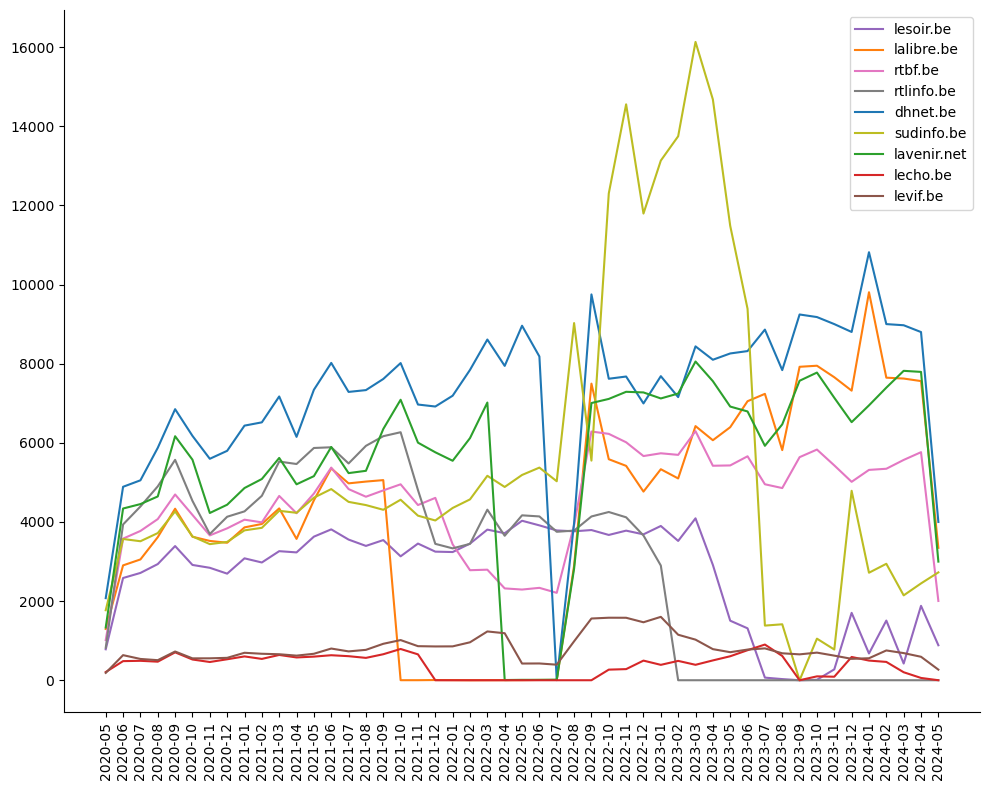

In [7]:
# Créer un dictionnaire pour associer les sources aux couleurs (copier-coller le dictionnaire de votre sortie)
source_color_mapping = {
    'dhnet.be': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
    'lalibre.be': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
    'lavenir.net': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
    'lecho.be': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
    'lesoir.be': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
    'levif.be': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
    'rtbf.be': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
    'rtlinfo.be': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
    'sudinfo.be': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)
}

# Initialiser les variables
articles_extraits_par_journal = {source: {} for source in relevant_sources}

for source in relevant_sources:
    articles_extraits_par_journal[source] = {}
    start_date = datetime(2020, 5, 1)
    end_date = datetime.now()
    delta = timedelta(days=1)
    
    while start_date < end_date:
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/non_covid/{source}/{filename}"
        
        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]
            
            month_year = start_date.strftime("%Y-%m")
            if month_year in articles_extraits_par_journal[source]:
                articles_extraits_par_journal[source][month_year] += len(articles)
            else:
                articles_extraits_par_journal[source][month_year] = len(articles)
        
        start_date += delta

# Initialiser la figure et les axes
fig, ax = plt.subplots()

# Graphique du nombre d'articles extraits par journal et par mois
for source in relevant_sources:
    months = list(articles_extraits_par_journal[source].keys())
    counts = list(articles_extraits_par_journal[source].values())
    color = source_color_mapping.get(source)  # Obtenir la couleur de la source
    ax.plot(months, counts, label=source, color=color)  # Ajouter la couleur à la ligne
    
# Ajoute la légende
ax.legend()

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()

output_directory = "./data/plots/corpus"
        
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "NON_COVID_Évolution du nombre d'articles extraits par journal.png")

plt.savefig(output_path)
plt.show()
plt.close()


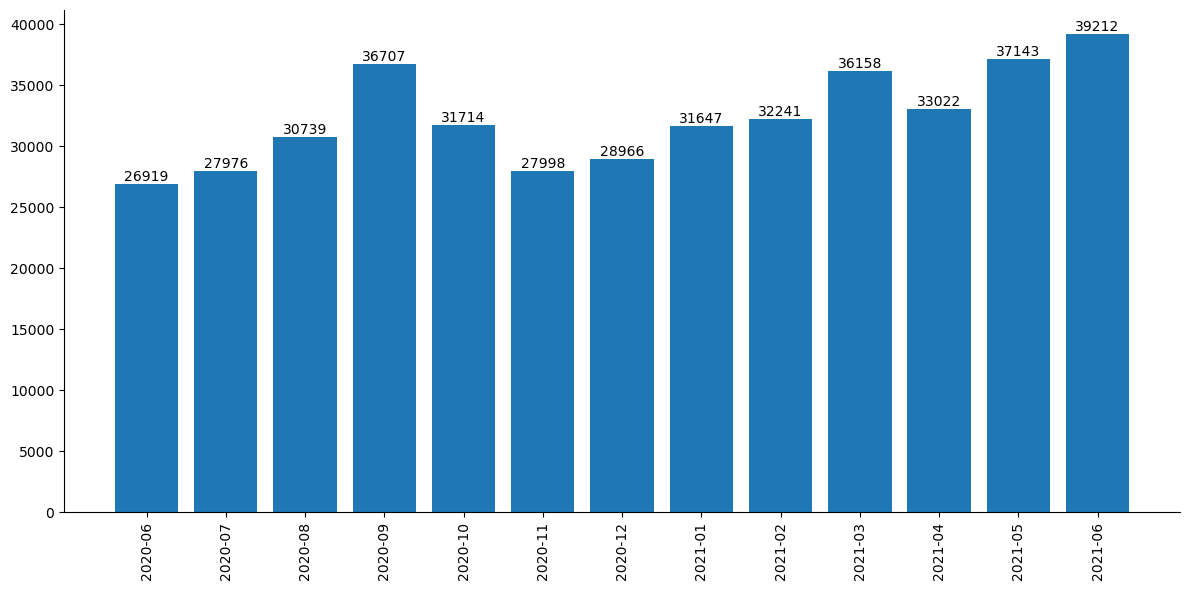

In [8]:
# Liste des sources pertinentes
relevant_sources = [
    "lesoir.be",
    "lalibre.be",
    "rtbf.be",
    "rtlinfo.be",
    "dhnet.be",
    "sudinfo.be",
    "lavenir.net",
    "lecho.be",
    "levif.be"
]

# Initialiser la variable pour stocker les données par mois
articles_extraits_par_mois = {}

# Parcourir les sources pertinentes
for source in relevant_sources:
    start_date = datetime(2020, 6, 1)
    end_date = datetime(2021, 6, 30)
    delta = timedelta(days=1)
    
    while start_date < end_date:
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/non_covid/{source}/{filename}"
        
        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]
            
            month_year = start_date.strftime("%Y-%m")
            if month_year in articles_extraits_par_mois:
                articles_extraits_par_mois[month_year] += len(articles)
            else:
                articles_extraits_par_mois[month_year] = len(articles)
        
        start_date += delta

# Trier les données par mois
sorted_articles_extraits_par_mois = dict(sorted(articles_extraits_par_mois.items()))

# Création du graphique en barres avec les valeurs au-dessus des barres
fig, ax = plt.subplots(figsize=(12, 6))
months = list(sorted_articles_extraits_par_mois.keys())
counts = list(sorted_articles_extraits_par_mois.values())

bars = ax.bar(months, counts)

# Ajout des valeurs au-dessus de chaque barre
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, '%d' % int(height), ha='center', va='bottom')

# Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.xticks(rotation=90)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Ajustements de mise en page
plt.tight_layout()

# Sauvegarde du graphique
output_directory = "./data/plots/corpus/non_covid"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "NON_COVID_Évolution du nombre d'articles extraits par mois_juin2020_juin2021.png")
plt.savefig(output_path)
plt.show()
plt.close()


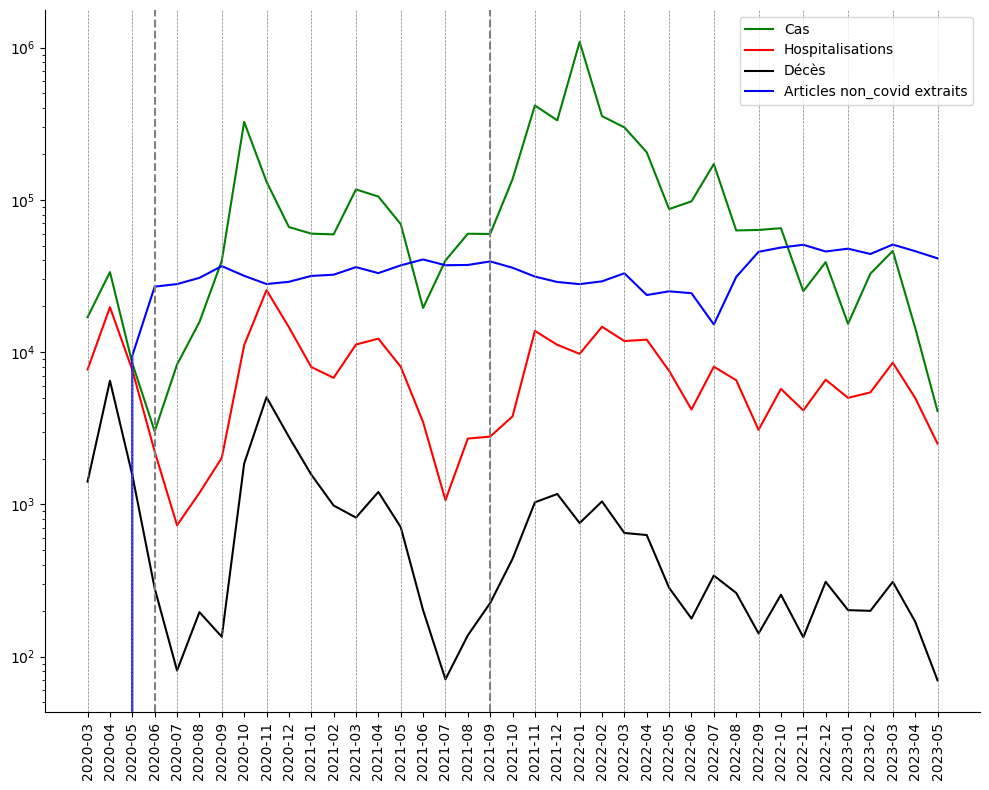

In [9]:
# Lecture des données à partir du fichier Excel
data = pd.read_excel("./data/sciensano/sciensano_final.xlsx")

# Extraction des colonnes pertinentes
months = data.iloc[:, 0].astype(str)
cases = data.iloc[:, 1]
hospitalizations = data.iloc[:, 2]
deaths = data.iloc[:, 3]

# Filtrage des données à extraire pour nos graphiques
start_index = months[months == '2020-03'].index[0]
end_index = months[months == '2023-05'].index[-1]
months_covid = sorted(months[start_index:end_index + 1])
cases = cases[start_index:end_index + 1]
hospitalizations = hospitalizations[start_index:end_index + 1]
deaths = deaths[start_index:end_index + 1]

# Lecture des données d'articles extraits
articles_extraits_par_mois = {}

for source in relevant_sources:
    start_date = datetime(2020, 3, 1)
    end_date = datetime(2023, 6, 1)
    delta = timedelta(days=1)

    while start_date < end_date:
        month_year = start_date.strftime("%Y-%m")
        
        if month_year not in articles_extraits_par_mois:
            articles_extraits_par_mois[month_year] = 0 
        
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/non_covid/{source}/{filename}"

        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]

            articles_extraits_par_mois[month_year] += len(articles)
            
        start_date += delta

# Création de la figure et les axes
fig, ax = plt.subplots()

# Graphique du nombre total de cas, hospitalisations et décès
ax.plot(months_covid, cases, label="Cas", color="green")
ax.plot(months_covid, hospitalizations, label="Hospitalisations", color="red")
ax.plot(months_covid, deaths, label="Décès", color="black")

# Graphique du nombre total d'articles extraits par mois en échelle logarithmique
months_articles = sorted(list(articles_extraits_par_mois.keys()))
counts_articles = [articles_extraits_par_mois[month_year] for month_year in months_articles]
ax.plot(months_articles, counts_articles, label="Articles non_covid extraits", color="blue")

# Ajout des lignes verticales pour chaque mois
for i, month in enumerate(months):
    if i % 2 == 0:
        ax.axvline(x=month, color='gray', linestyle='--', linewidth=0.5)

# Ajout des lignes verticales spécifiques à juin 2020 et septembre 2021
ax.axvline(x='2020-06', color='gray', linestyle='--', linewidth=1.5)
ax.axvline(x='2021-09', color='gray', linestyle='--', linewidth=1.5)

# Applique une échelle logarithmique sur l'axe des y
ax.set_yscale("log")

# Ajoute la légende et les étiquettes d'axe
ax.legend()

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.tight_layout()

output_directory = "./data/plots/corpus"
        
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "NON_COVID_Évolution du nombre de cas, d'hospitalisations, de décès et d'articles extraits.png")

plt.savefig(output_path)
plt.show()
plt.close()


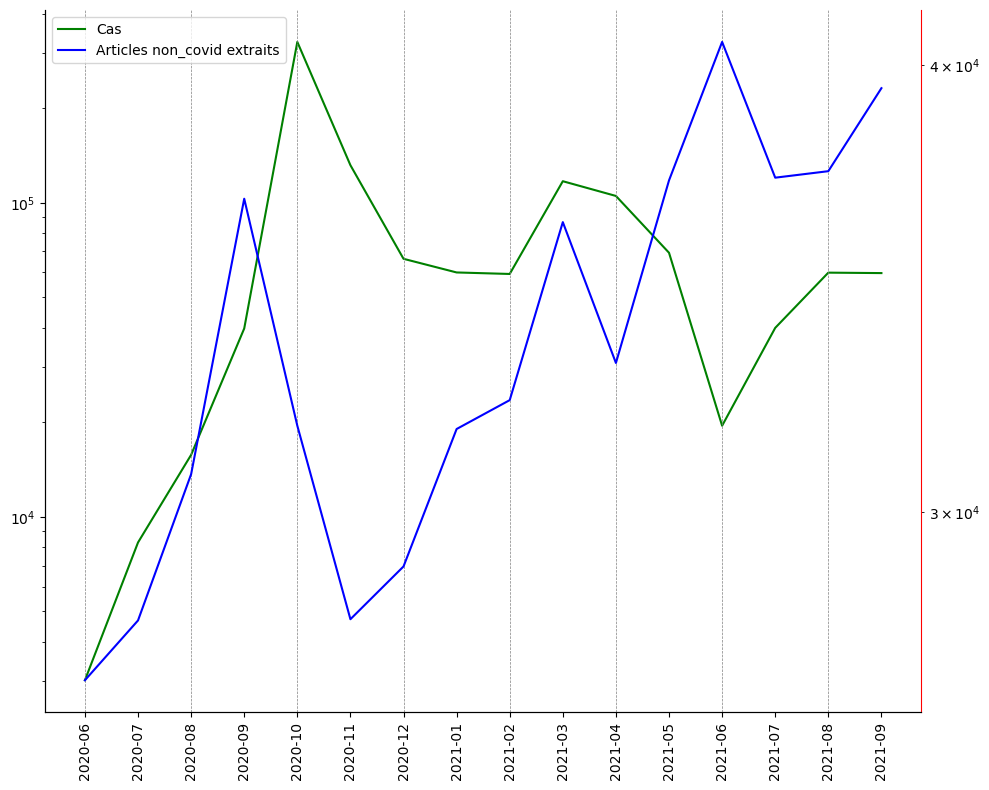

In [10]:
# Lecture des données à partir du fichier Excel
data = pd.read_excel("./data/sciensano/sciensano_final.xlsx")

relevant_sources = [
    "lesoir.be",
    "lalibre.be",
    "rtbf.be",
    "rtlinfo.be",
    "dhnet.be",
    "sudinfo.be",
    "lavenir.net",
    "lecho.be",
    "levif.be"
]

# Extraction des colonnes pertinentes
months = data.iloc[:, 0].astype(str)
cases = data.iloc[:, 1]

# Filtrage des données à extraire pour nos graphiques
start_index = months[months == '2020-06'].index[0]
end_index = months[months == '2021-09'].index[-1]
months_covid = sorted(months[start_index:end_index + 1])
cases = cases[start_index:end_index + 1]

# Lecture des données d'articles extraits
articles_extraits_par_mois = {}

for source in relevant_sources:
    start_date = datetime(2020, 6, 1)
    end_date = datetime(2021, 10, 1)
    delta = timedelta(days=1)
    
    while start_date < end_date:
        month_year = start_date.strftime("%Y-%m")
        
        if month_year not in articles_extraits_par_mois:
            articles_extraits_par_mois[month_year] = 0 
        
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/non_covid/{source}/{filename}"
        
        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]

            articles_extraits_par_mois[month_year] += len(articles)

        start_date += delta
        
# Création du premier graphique : nombre de cas
fig, ax1 = plt.subplots()
ax1.plot(months_covid, cases, label="Cas", color="green")
ax1.set_yscale("log")

# Création du deuxième graphique : nombre d'articles extraits
ax2 = ax1.twinx()
months_articles = sorted(list(articles_extraits_par_mois.keys()))
counts_articles = [articles_extraits_par_mois[month_year] for month_year in months_articles]
ax2.plot(months_articles, counts_articles, label="Articles non_covid extraits", color='blue')
ax2.spines['right'].set_color('red')
ax2.set_yscale("log")

# Fusionner les légendes des deux axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Ajout des lignes verticales tous les deux mois sur l'axe des cas (ax1)
for i, month in enumerate(months_covid):
    if i % 2 == 0:
        ax1.axvline(x=month, color='gray', linestyle='--', linewidth=0.5)

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# Afficher les étiquettes d'axe des x à la verticale
plt.setp(ax1.get_xticklabels(), rotation=90)

plt.tight_layout()

output_directory = "./data/plots/corpus"
        
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "NON_COVID_Comparaison du nombre de cas et d'articles extraits.png")

plt.savefig(output_path)
plt.show()
plt.close()


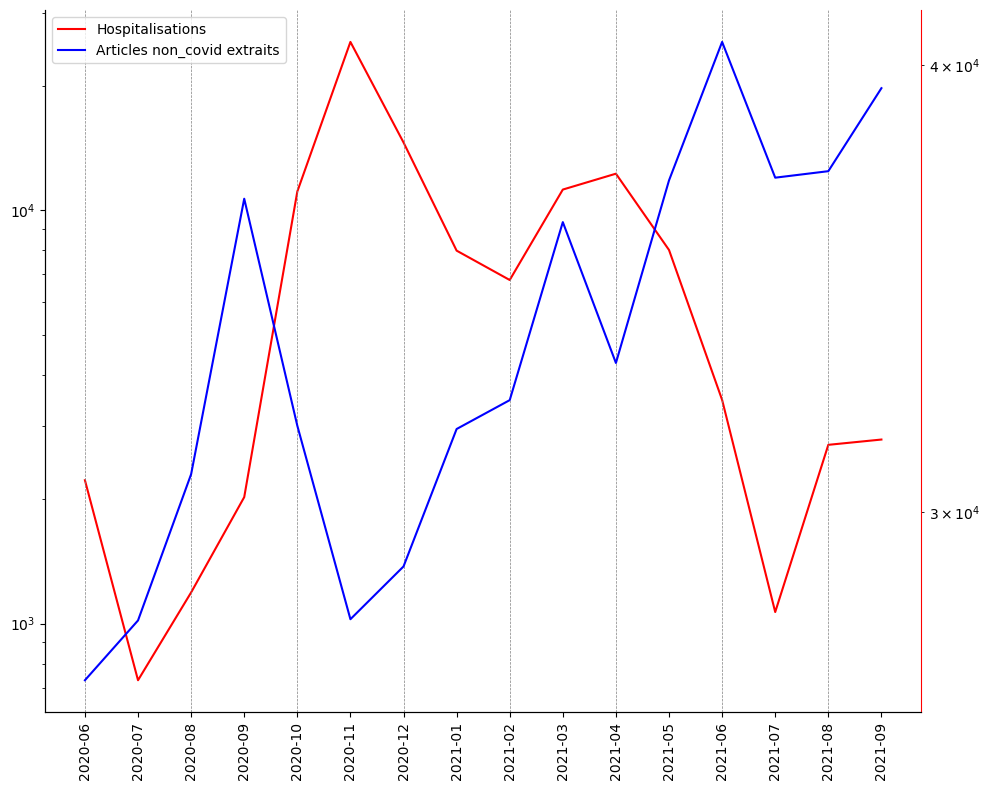

In [11]:
# Lecture des données à partir du fichier Excel
data = pd.read_excel("./data/sciensano/sciensano_final.xlsx")

# Extraction des colonnes pertinentes
months = data.iloc[:, 0].astype(str)
hospitalizations = data.iloc[:, 2]

# Filtrage des données à extraire pour nos graphiques
start_index = months[months == '2020-06'].index[0]
end_index = months[months == '2021-09'].index[-1]
months_covid = sorted(months[start_index:end_index + 1])
hospitalizations = hospitalizations[start_index:end_index + 1]

# Lecture des données d'articles extraits
articles_extraits_par_mois = {}

for source in relevant_sources:
    start_date = datetime(2020, 6, 1)
    end_date = datetime(2021, 10, 1)
    delta = timedelta(days=1)
    
    while start_date < end_date:
        month_year = start_date.strftime("%Y-%m")
        
        if month_year not in articles_extraits_par_mois:
            articles_extraits_par_mois[month_year] = 0  # Initialisation à zéro
        
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/non_covid/{source}/{filename}"

        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]

            articles_extraits_par_mois[month_year] += len(articles)

        start_date += delta

# Création du premier graphique : nombre d'hospitalisations
fig, ax1 = plt.subplots()
ax1.plot(months_covid, hospitalizations, label="Hospitalisations", color="red")
ax1.set_yscale("log")

# Création du deuxième graphique : nombre d'articles extraits
ax2 = ax1.twinx()
months_articles = sorted(list(articles_extraits_par_mois.keys()))
counts_articles = [articles_extraits_par_mois[month_year] for month_year in months_articles]
ax2.plot(months_articles, counts_articles, label="Articles non_covid extraits", color='blue')
ax2.spines['right'].set_color('red')
ax2.set_yscale("log")

# Fusionner les légendes des deux axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Ajout des lignes verticales tous les deux mois sur l'axe des cas (ax1)
for i, month in enumerate(months_covid):
    if i % 2 == 0:
        ax1.axvline(x=month, color='gray', linestyle='--', linewidth=0.5)

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# Afficher les étiquettes d'axe des x à la verticale
plt.setp(ax1.get_xticklabels(), rotation=90)

plt.tight_layout()

output_directory = "./data/plots/corpus"
        
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "NON_COVID_Comparaison du nombre d'hospitalisations et d'articles extraits pour toutes les sources.png")

plt.savefig(output_path)
plt.show()
plt.close()


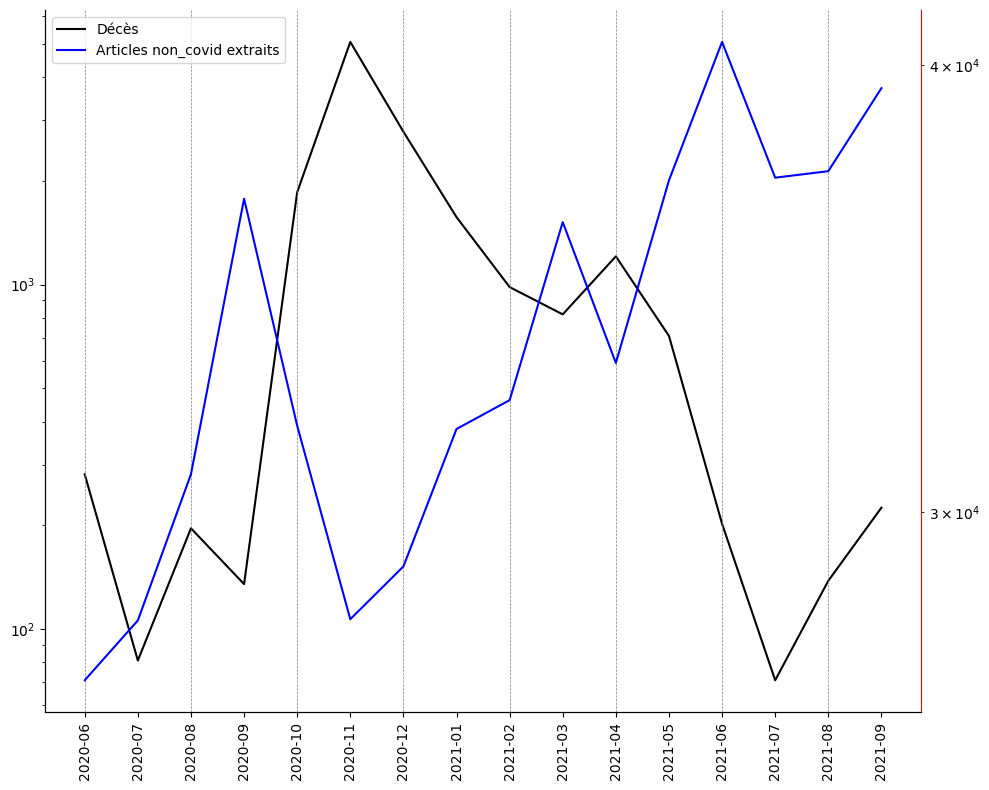

In [12]:
# Lecture des données à partir du fichier Excel
data = pd.read_excel("./data/sciensano/sciensano_final.xlsx")

# Extraction des colonnes pertinentes
months = data.iloc[:, 0].astype(str)
deaths = data.iloc[:, 3]

# Filtrage des données à extraire pour nos graphiques
start_index = months[months == '2020-06'].index[0]
end_index = months[months == '2021-09'].index[-1]
months_covid = sorted(months[start_index:end_index + 1])
deaths = deaths[start_index:end_index + 1]

# Lecture des données d'articles extraits
articles_extraits_par_mois = {}

for source in relevant_sources:
    start_date = datetime(2020, 6, 1)
    end_date = datetime(2021, 10, 1)
    delta = timedelta(days=1)
    
    while start_date < end_date:
        month_year = start_date.strftime("%Y-%m")
        
        if month_year not in articles_extraits_par_mois:
            articles_extraits_par_mois[month_year] = 0
        
        filename = source + "_" + start_date.strftime("%Y%m%d") + ".json"
        filepath = f"./data/non_covid/{source}/{filename}"

        if os.path.isfile(filepath):
            with open(filepath, "r", encoding="utf-8") as f:
                articles = [json.loads(line) for line in f]

            articles_extraits_par_mois[month_year] += len(articles)

        start_date += delta

# Création du premier graphique : nombre de décès
fig, ax1 = plt.subplots()
ax1.plot(months_covid, deaths, label="Décès", color="black")
ax1.set_yscale("log")

# Création du deuxième graphique : nombre d'articles extraits
ax2 = ax1.twinx()
months_articles = sorted(list(articles_extraits_par_mois.keys()))
counts_articles = [articles_extraits_par_mois[month_year] for month_year in months_articles]
ax2.plot(months_articles, counts_articles, label="Articles non_covid extraits", color='blue')
ax2.spines['right'].set_color('red')
ax2.set_yscale("log")

# Fusionner les légendes des deux axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Ajout des lignes verticales tous les deux mois sur l'axe des cas (ax1)
for i, month in enumerate(months_covid):
    if i % 2 == 0:
        ax1.axvline(x=month, color='gray', linestyle='--', linewidth=0.5)

# Ajustements de mise en page
fig.set_size_inches(10, 8)
plt.xticks(rotation=90)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

# Afficher les étiquettes d'axe des x à la verticale
plt.setp(ax1.get_xticklabels(), rotation=90)

plt.tight_layout()

output_directory = "./data/plots/corpus"
        
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

output_path = os.path.join(output_directory, "NON_COVID_Comparaison du nombre de décès et d'articles extraits pour toutes les sources.png")

plt.savefig(output_path)
plt.show()
plt.close()


In [13]:
def get_date_from_filename(filename):
    date_str = filename.split('_')[-1].split('.')[0]
    date_obj = datetime.strptime(date_str, "%Y%m%d")
    return date_obj.strftime("%b %Y")

def count_words(text):
    # Cette fonction compte le nombre de mots dans le texte en utilisant la tokenisation nltk.
    return len(word_tokenize(text))

def average_word_count_by_month(directory):
    average_word_counts = {}
    total_words_by_month = {}
    total_texts_by_month = {}

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        if not os.path.isfile(file_path) or not file_path.endswith('.json'):
            continue

        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                try:
                    data = json.loads(line)
                    text = data.get('text')
                    if text:
                        date_str = get_date_from_filename(filename)
                        total_words_by_month[date_str] = total_words_by_month.get(date_str, 0) + count_words(text)
                        total_texts_by_month[date_str] = total_texts_by_month.get(date_str, 0) + 1
                except json.JSONDecodeError:
                    continue

    for date_str in total_words_by_month:
        if total_texts_by_month[date_str] > 0:
            average_word_counts[date_str] = int(total_words_by_month[date_str] / total_texts_by_month[date_str])
        else:
            average_word_counts[date_str] = 0

    return average_word_counts


relevant_sources = ['lesoir.be', 'lalibre.be', 'rtbf.be', 'rtlinfo.be', 'dhnet.be', 'sudinfo.be', 'lavenir.net', 'lecho.be', 'levif.be']

for source in relevant_sources:
    data_directory = f"./data/non_covid/{source}"
    average_word_counts = average_word_count_by_month(data_directory)
    print(f"Source : {source}")
    print("-------------------")
    print(f"Nombre moyen de mots par texte par mois : {average_word_counts}")
    print("-------------------")


Source : lesoir.be
-------------------
Nombre moyen de mots par texte par mois : {'May 2020': 185, 'Jun 2020': 189, 'Jul 2020': 186, 'Aug 2020': 183, 'Sep 2020': 184, 'Oct 2020': 184, 'Nov 2020': 177, 'Dec 2020': 185, 'Jan 2021': 179, 'Feb 2021': 180, 'Mar 2021': 178, 'Apr 2021': 175, 'May 2021': 176, 'Jun 2021': 189, 'Jul 2021': 172, 'Aug 2021': 174, 'Sep 2021': 176, 'Oct 2021': 215, 'Nov 2021': 231, 'Dec 2021': 229, 'Jan 2022': 220, 'Feb 2022': 243, 'Mar 2022': 247, 'Apr 2022': 242, 'May 2022': 235, 'Jun 2022': 231, 'Jul 2022': 232, 'Aug 2022': 225, 'Sep 2022': 243, 'Oct 2022': 243, 'Nov 2022': 245, 'Dec 2022': 248, 'Jan 2023': 237, 'Feb 2023': 230, 'Mar 2023': 228, 'Apr 2023': 207, 'May 2023': 200, 'Jun 2023': 203, 'Jul 2023': 203, 'Aug 2023': 87, 'Oct 2023': 83, 'Nov 2023': 215, 'Dec 2023': 235, 'Jan 2024': 210, 'Feb 2024': 213, 'Mar 2024': 217, 'Apr 2024': 225, 'May 2024': 212}
-------------------
Source : lalibre.be
-------------------
Nombre moyen de mots par texte par mois : {'

In [14]:
import os
from datetime import datetime
from nltk.tokenize import word_tokenize
import json

def get_date_from_filename(filename):
    date_str = filename.split('_')[-1].split('.')[0]
    date_obj = datetime.strptime(date_str, "%Y%m%d")
    return date_obj.strftime("%b %Y")

def count_words(text):
    return len(word_tokenize(text))

def average_word_count_by_month(directory):
    average_word_counts = {}
    total_words_by_month = {}
    total_texts_by_month = {}

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        if not os.path.isfile(file_path) or not file_path.endswith('.json'):
            continue

        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                try:
                    data = json.loads(line)
                    text = data.get('text')
                    if text:
                        date_str = get_date_from_filename(filename)
                        total_words_by_month[date_str] = total_words_by_month.get(date_str, 0) + count_words(text)
                        total_texts_by_month[date_str] = total_texts_by_month.get(date_str, 0) + 1
                except json.JSONDecodeError:
                    continue

    for date_str in total_words_by_month:
        if total_texts_by_month[date_str] > 0:
            average_word_counts[date_str] = total_words_by_month[date_str] / total_texts_by_month[date_str]
        else:
            average_word_counts[date_str] = 0

    return average_word_counts

def average_word_count_by_source(directory, start_date, end_date):
    total_words_by_source = {}
    total_texts_by_source = {}
    total_months = 0

    for source in relevant_sources:
        data_directory = os.path.join(directory, source)
        average_word_counts = average_word_count_by_month(data_directory)
        
        for month, word_count in average_word_counts.items():
            date_obj = datetime.strptime(month, "%b %Y")
            if start_date <= date_obj <= end_date:
                total_words_by_source[source] = total_words_by_source.get(source, 0) + word_count
                total_texts_by_source[source] = total_texts_by_source.get(source, 0) + 1
                total_months += 1

    average_word_counts_by_source = {}
    for source in total_words_by_source:
        if total_texts_by_source[source] > 0:
            average_word_counts_by_source[source] = total_words_by_source[source] / total_texts_by_source[source]
        else:
            average_word_counts_by_source[source] = 0

    return average_word_counts_by_source

relevant_sources = ['lesoir.be', 'lalibre.be', 'rtbf.be', 'rtlinfo.be', 'dhnet.be', 'sudinfo.be', 'lavenir.net', 'lecho.be', 'levif.be']

start_date = datetime(2020, 6, 1)
end_date = datetime(2021, 6, 30)

data_directory = "./data/non_covid"
average_word_counts_by_source = average_word_count_by_source(data_directory, start_date, end_date)

print("Moyenne de mots par texte par source pour la période de juin 2020 à juin 2021 :")
print("-------------------")
for source, average_word_count in average_word_counts_by_source.items():
    print(f"Source : {source}, Moyenne de mots : {average_word_count}")
print("-------------------")


Moyenne de mots par texte par source pour la période de juin 2020 à juin 2021 :
-------------------
Source : lesoir.be, Moyenne de mots : 182.41262969208495
Source : lalibre.be, Moyenne de mots : 343.2973133123714
Source : rtbf.be, Moyenne de mots : 385.68683054648267
Source : rtlinfo.be, Moyenne de mots : 399.0419783811098
Source : dhnet.be, Moyenne de mots : 298.93559441165723
Source : sudinfo.be, Moyenne de mots : 289.1930086817947
Source : lavenir.net, Moyenne de mots : 139.61540434223235
Source : lecho.be, Moyenne de mots : 592.3922868469058
Source : levif.be, Moyenne de mots : 830.0928389155093
-------------------
